## Семинар 6 "Segmentation"

ФИО: Усцов Артем Алексеевич

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 15 декабря 2022).  
Скорее всего будут дополнительные плюшки для призеров конкурса.


In [ ]:
# !pip install pytorch_lightning
# !pip install imagecodecs-lite
# !pip install --upgrade tifffile

In [ ]:
!wget https://www.dropbox.com/sh/z4hbbzqai0ilqht/AADp_8oefNFs2bjC2kzl2_Fqa/training.zip -P dataset/
!wget https://www.dropbox.com/sh/z4hbbzqai0ilqht/AABuUJQJ5yG5oCuziYzYu8jWa/test.zip -P dataset/

In [ ]:
!unzip dataset/test.zip
!unzip dataset/training.zip && mv ./training ./train

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms as tsf
import scipy.misc
import torch.nn as nn
from pathlib import Path
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


from PIL import Image
import skimage
from skimage import io
from imagecodecs import imread

from torch.utils.tensorboard import SummaryWriter

TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [2]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data

In [3]:
test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('train/images', "train/1st_manual/")

In [4]:
import PIL
class Dataset():
    def __init__(
        self,data,
        source_transform,
        target_transform,
    ):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform

    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask

    def __len__(self):
        return len(self.datas)

/var/folders/_y/9291qqf96ggfppmhhxx_g3040000gq/T/ipykernel_18567/715362971.py:25: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  tsf.Resize((128,128),interpolation=PIL.Image.NEAREST),
/Users/a.ustsov/technopark/DL_Homeworks/venv/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [ ]:
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)

In [ ]:
dataset = Dataset(train_data, s_trans, t_trans)
dataloader = t.utils.data.DataLoader(dataset, num_workers=2, batch_size=4)

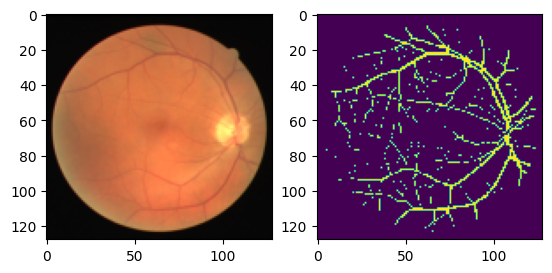

In [20]:
img,mask = dataset[12]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [6]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch) 

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = double_conv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = nn.Conv2d(64, n_channels, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = F.sigmoid(x)
        return x

In [7]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

In [8]:
model = UNet()

TypeError: UNet.__init__() missing 2 required positional arguments: 'n_channels' and 'n_classes'

In [ ]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [ ]:
os.makedirs("result")
!zip -r result.zip result

In [ ]:
model = model.eval()
for ex_id, data in enumerate(testdataloader):
    data = t.autograd.Variable(data, volatile=True).cuda()
    o = model(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    
    scipy.misc.imsave("test/result/%s.png" % (ex_id + 1), tm)

In [ ]:
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)